In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
#import sympy
#import functools 
#from datetime import timedelta
#import wordninja as wrd
from pandas.tseries.frequencies import to_offset
from pandas.tseries.offsets import DateOffset
from sympy.stats import Normal, cdf
from scipy import stats

In [76]:
FWD_Price = pd.read_csv('PricesFile1.csv')

int_rate = pd.read_csv('InterestRates.csv')

NG_impvol_2020 = pd.read_csv('NG_ImpliedVols 2020.csv')
NG_impvol_2021 = pd.read_csv('NG_ImpliedVols 2021.csv')
NG_impvol_2022 = pd.read_csv('NG_ImpliedVols 2022.csv')

NG_price = FWD_Price.loc[FWD_Price.priceindex == "NYMEX Natural Gas"].drop(['priceindex'],axis=1)
NG_price = NG_price.loc[(NG_price.pricedate < NG_price.delivdate)]
#NG_price = NG_price.loc[FWD_Price.price < 0]

NG_price.pricedate = pd.to_datetime(NG_price.pricedate, format='%Y-%m-%d')
NG_price.delivdate = pd.to_datetime(NG_price.delivdate, format='%Y-%m-%d')


int_rate.pricedate = pd.to_datetime(int_rate.pricedate, format='%Y-%m-%d')

for i in range(len(int_rate.pricedate)):
    p_time = int_rate.pricedate[i]
    m_time = int_rate.maturity[i]
    maturedate  = p_time + to_offset(m_time)
    int_rate.maturity[i] = maturedate

int_rate.maturity =  pd.to_datetime(int_rate.maturity, format='%Y-%m-%d %H:%M:%s')  
int_rate = int_rate.loc[int_rate.maturity < "2022-12-31"]

delv_date = int_rate.maturity - pd.offsets.MonthBegin(1, normalize=True)
int_rate = int_rate.assign(delivdate = delv_date)

vol_frame = [NG_impvol_2020 , NG_impvol_2021 , NG_impvol_2022]
NG_vols = pd.concat(vol_frame , join ='inner').drop(['volatilityindex'],axis=1)
NG_vols.volatilitydate = pd.to_datetime(NG_vols.volatilitydate)
NG_vols.begtime = pd.to_datetime(NG_vols.begtime)
NG_vols = NG_vols.rename(columns={"volatilitydate":"t","begtime":"Tf","strikeprice":"K","volatility":"sigma"})

NG_pri_int = pd.merge(NG_price, int_rate, how= 'inner', on = ['pricedate','delivdate'])
NG_pri_int = NG_pri_int.rename(columns={"pricedate":"t","delivdate":"Tf", "price":"F", "bidrate":"r"})

NG_df = NG_vols.merge(NG_pri_int , how='inner' , on =['t','Tf'], sort = True)

Te = NG_df.Tf - DateOffset(days=1)
NG_df = NG_df.assign(Te = Te)


#NG_df = NG_df.loc[NG_df.Tf > NG_df.Te]
NG_df = NG_df.reset_index(drop=True)

#NG_df = NG_df.groupby(['t','Tf','F','r'])['sigma','K'].mean()
#NG_df = NG_df.get_group(['F'])
display(NG_df)

<ipython-input-76-874a3d4587eb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_rate.maturity[i] = maturedate


,t,K,Tf,sigma,F,maturity,r,Te
0,2020-03-02,1.03,2020-04-01,0.592,1.755,2020-04-30,0.995003,2020-03-31
1,2020-03-02,1.08,2020-04-01,0.576,1.755,2020-04-30,0.995003,2020-03-31
2,2020-03-02,1.13,2020-04-01,0.562,1.755,2020-04-30,0.995003,2020-03-31
3,2020-03-02,1.18,2020-04-01,0.548,1.755,2020-04-30,0.995003,2020-03-31
4,2020-03-02,1.23,2020-04-01,0.535,1.755,2020-04-30,0.995003,2020-03-31
...,...,...,...,...,...,...,...,...
147403,2020-05-29,4.80,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147404,2020-05-29,4.85,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147405,2020-05-29,4.90,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147406,2020-05-29,4.95,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31


In [77]:
def call_option (df):
    
    delta_t = df.Te - df.t
    time_diff = (delta_t.dt.days)/365
    
    d1 = (np.log(df.F / df.K) + (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    d2 = (np.log(df.F / df.K) - (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    
    Call = np.exp(- (df.r/100) * time_diff) * (df.F * si.norm.cdf(d1) - df.K * si.norm.cdf(d2))
    
    return Call

call = call_option(NG_df)

NG_option = NG_df.assign(B76_call =call)
NG_option = NG_option.loc[NG_option.F > NG_option.K]
display(NG_option)

,t,K,Tf,sigma,F,maturity,r,Te,B76_call
0,2020-03-02,1.03,2020-04-01,0.592,1.755,2020-04-30,0.995003,2020-03-31,0.724469
1,2020-03-02,1.08,2020-04-01,0.576,1.755,2020-04-30,0.995003,2020-03-31,0.674555
2,2020-03-02,1.13,2020-04-01,0.562,1.755,2020-04-30,0.995003,2020-03-31,0.624688
3,2020-03-02,1.18,2020-04-01,0.548,1.755,2020-04-30,0.995003,2020-03-31,0.574902
4,2020-03-02,1.23,2020-04-01,0.535,1.755,2020-04-30,0.995003,2020-03-31,0.525268
...,...,...,...,...,...,...,...,...,...
147350,2020-05-29,2.20,2022-11-01,0.183,2.445,2022-11-30,0.315002,2022-10-31,0.400283
147351,2020-05-29,2.25,2022-11-01,0.183,2.445,2022-11-30,0.315002,2022-10-31,0.371765
147352,2020-05-29,2.30,2022-11-01,0.184,2.445,2022-11-30,0.315002,2022-10-31,0.346187
147353,2020-05-29,2.35,2022-11-01,0.184,2.445,2022-11-30,0.315002,2022-10-31,0.320735


In [78]:
def LSR (NG_df1):
    
    S_x = sum(NG_df1.F) - NG_df1.F.iloc[-1]
    S_y = sum(NG_df1.F) - NG_df1.F.iloc[0]
    S_xx = sum((NG_df1.F)**2) - ((NG_df1.F.iloc[-1])**2)
    S_yy = sum((NG_df1.F)**2) - ((NG_df1.F.iloc[0])**2)
    S_xy = 0
    for i in range(1,len(NG_df1.F)):
        S_xy = S_xy + (NG_df1.F.iloc[i-1] * NG_df1.F.iloc[i])
        

    n = len(NG_df1.F)

    a = (n*S_xy - (S_x*S_y)) / (n*S_xx - S_x**2)
    b = (S_y - a*S_x) / n
    sd_e = np.sqrt((n*S_yy - S_y**2 - a*(n*S_xy - S_x*S_y)) / (n*(n-2)))

    delta = 1

    lmbd = -((np.log(a)) / delta)
    mu = b / (1-a)
    sigm = sd_e* np.sqrt((-2*np.log(a)) / (delta*(1-a**2)))

    S = np.zeros(n)
    #T = np.zeros(n)

    S[0] = NG_df1.F.iloc[-1]
    #T[0] = 0
    mpr = NG_df1.r.iloc[0]

    for i in range(1, len(S)):
        lmbd_star = lmbd + (mpr*sigm)
        mu_star = (lmbd*mu) / (lmbd + mpr*sigm)
        #diffu = sigm * np.sqrt((1-np.exp(-2*lmbd*delta))/(2*lmbd)) * np.random.rand()
        #S[i] = (S[i-1] * np.exp(-lmbd*delta)) + (mu * (1-np.exp(-lmbd*delta))) + diffu
        diffu = sigm * np.sqrt((1-np.exp(-2*lmbd_star*delta))/(2*lmbd_star)) * np.random.rand()
        S[i] = (S[i-1] * np.exp(-lmbd_star*delta)) + (mu_star * (1-np.exp(-lmbd_star*delta))) + diffu
        #T[i] = T[i-1] + delta
        
        mpr = (((S[i]-S[i-1])/S[i-1]) - (NG_df1.r.iloc[i]/100)) /  NG_df1.sigma.iloc[i] 
    
    
    return S , lmbd_star , mu_star

In [79]:
t = pd.to_datetime('2020-05-29', format = '%Y-%m-%d')
NG_option = NG_option.loc[NG_option.t == t]
#.sort_values(by=['Tf']).reset_index(drop=True)
NG_option = NG_option.groupby(['Tf', 'Te','r','K','F','B76_call'],as_index=False).mean()

#Tf = pd.to_datetime('2021-03-01', format = '%Y-%m-%d')
#NG_option = NG_option.loc[NG_option.Tf == Tf]

#NG_option.Te.unique()
#Te = pd.to_datetime('2021-03-31', format = '%Y-%m-%d')
#NG_option = NG_option.loc[NG_option.Te == Te]
pd.set_option('display.max_rows', 900)
NG_option


,Tf,Te,r,K,F,B76_call,sigma
0,2020-07-01,2020-06-30,0.290001,1.03,1.848,0.818111,0.732
1,2020-07-01,2020-06-30,0.290001,1.08,1.848,0.768435,0.729
2,2020-07-01,2020-06-30,0.290001,1.10,1.848,0.748682,0.734
3,2020-07-01,2020-06-30,0.290001,1.15,1.848,0.699410,0.732
4,2020-07-01,2020-06-30,0.290001,1.20,1.848,0.650572,0.730
5,2020-07-01,2020-06-30,0.290001,1.25,1.848,0.602379,0.729
6,2020-07-01,2020-06-30,0.290001,1.30,1.848,0.554982,0.727
7,2020-07-01,2020-06-30,0.290001,1.35,1.848,0.508702,0.726
8,2020-07-01,2020-06-30,0.290001,1.40,1.848,0.463764,0.725
9,2020-07-01,2020-06-30,0.290001,1.45,1.848,0.420531,0.725


In [70]:
K=2.60
lmbd_star = 0
mu_star =0
payoff = 0
matur = pd.to_datetime('2021-05-01', format = '%Y-%m-%d')
delta_t = matur -t
time_diff = (delta_t.days) /365
r=0.29001
trial = 5
    
for i in range(trial):
    F , lmbd_star , mu_star= LSR(NG_option)
        #plt.plot(time, F , markersize=12)
    lmbd_star += lmbd_star
    mu_star += mu_star
    payoff = payoff + max((F.mean() - K) , 0)
    
a = (lmbd_star/trial)
b = (mu_star / trial)
call =  np.exp(-((r/100)) * time_diff) * ( payoff / trial )
call , a , b


(1.4891537408872222, 0.0030716966110630856, 1.1623514662338823)

In [344]:
#t = pd.to_datetime('2020-03-02', format = '%Y-%m-%d')
#NG_df1 = NG_df.loc[NG_df.t == t]
#NG_df1 = NG_df.groupby(['Tf','Te','r'],as_index=False).mean()
#NG_df1

,maturity,f price,volatility,strike,GARCH-call
0,2020-08-31,1.987,0.745,1.00,3.093030
1,2021-01-31,2.918,0.509,1.10,2.995654
2,2022-07-31,2.372,0.209,1.23,2.849988
3,2020-09-30,2.067,0.720,1.30,2.791513
4,2021-07-31,2.579,0.401,1.38,2.710797
5,2021-05-31,2.525,0.397,1.38,2.712052
6,2022-02-28,2.668,0.294,1.48,2.591015
7,2022-02-28,2.668,0.319,1.65,2.422449
8,2022-08-31,2.360,0.190,1.75,2.326385
9,2022-05-31,2.324,0.201,1.75,2.320546


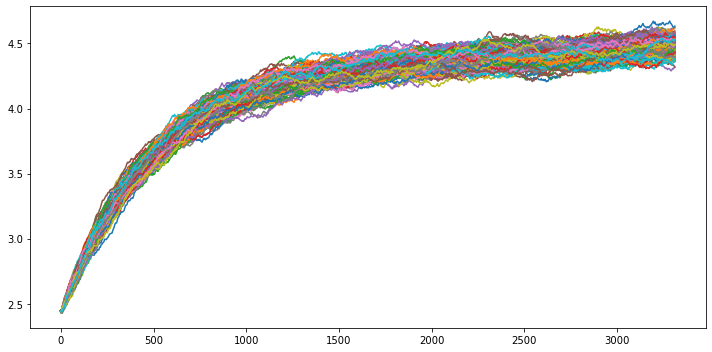

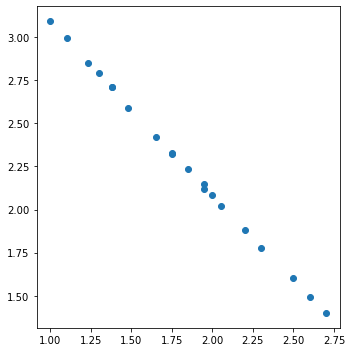

In [83]:
trial = 10
nrows = 20

R = np.random.randint(0,len(NG_option.F),nrows)

call = np.zeros(nrows)
strike = np.zeros(nrows)
t_call = np.empty(nrows, dtype='datetime64[us]') 
price = np.zeros(nrows)
sigma_c = np.zeros(nrows)

n=len(NG_option.F)
dt=.25
T = int(n / dt)
time = np.linspace(0., T, n)

fig = plt.figure(figsize=(10,5), tight_layout=True)

for j in range(nrows):
    lmbd_star = 0
    payoff = 0
    index = R[j]
    delta_t = NG_option.Te.iloc[index] -t
    time_diff = (delta_t.days) /365
    K = NG_option.K.iloc[index]
    
    for i in range(trial):
       
        F , lmbd_star , mu_star= LSR(NG_option)
        plt.plot(time , F , markersize=12)
        lmbd_star += lmbd_star
        payoff = payoff + max((F.mean() - K) , 0)
    
    a = (lmbd_star/trial)
    call[j] =  np.exp(-((NG_option.r.iloc[index]/100) + a) * time_diff) * ( payoff / trial )
    t_call[j] = NG_option.Te.iloc[index]
    strike[j] = NG_option.K.iloc[index]
    price[j] = NG_option.F.iloc[index]
    sigma_c[j] = NG_option.sigma.iloc[index]

op_str = pd.DataFrame(data={'maturity':t_call, 'f price':price, 'volatility': sigma_c, 'strike': strike, 'GARCH-call': call})
op_str = op_str.sort_values(by=['strike']).reset_index(drop=True)
#op_str.drop(["maturity","f price"], axis=1).plot.line(x='strike', y='call option', subplots = False ,figsize=(20,10))
display(op_str) 


fig = plt.figure(figsize=(5,5), tight_layout=True)
plt.scatter(strike, call)

In [339]:
NG_option = NG_option.drop(["Tf","r"], axis=1)
#NG_option = NG_option.loc[NG_option.Te.isin(t_call)]
#NG_option = NG_option.loc[NG_option.F.isin(price)]
#NG_option = NG_option.loc[NG_option.sigma.isin(sigma_c)]
#NG_option = NG_option.loc[NG_option.K.isin(strike)]
NG_option = NG_option.rename(columns={"Te":"maturity", "F":"f price", "K":"strike", "sigma":"volatility"})
NG_option = NG_option.merge(op_str, how='inner', on=['maturity','f price','strike','volatility'],sort=False)


display(NG_option)


,maturity,strike,f price,B76_call,volatility,GARCH-call
0,2020-11-30,1.70,2.378,0.698473,0.302,1.938999
1,2020-11-30,1.70,2.378,0.698212,0.302,1.938999
2,2021-04-30,1.23,2.139,0.911152,0.307,2.409612
3,2021-06-30,1.48,2.236,0.777125,0.284,2.140828
4,2022-04-30,1.95,2.216,0.367094,0.177,1.661872
5,2022-10-31,2.35,2.420,0.269978,0.155,1.251427
